In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.tree import export_graphviz
from tensorflow.python import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
print(tf.__version__)

2.0.0


Using TensorFlow backend.


In [2]:
TRAIN_DIR = "./input/train"
TEST_DIR = "./input/test"

TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)

VALID_FRACTION = 0.3
BATCH_SIZE = 500
EPOCHS = 8
IMAGE_WIDTH = IMAGE_HEIGHT = 128

Number of training images: 6501
Number of test images: 101


In [3]:
# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []
for filename in train_filenames:
    label = filename.split('__')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

In [4]:
train_df=train_df.drop(train_df.index[0])

In [5]:
# splitting to train & valid
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)

In [6]:
#augmentation settings, for now just normalizing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

In [7]:
# not doing any data augmentation on validation test set
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [8]:
# creating train and valid generators (not using valid_split to avoid doing data augmentation on validation set)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 4550 validated image filenames belonging to 100 classes.


In [9]:
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1950 validated image filenames belonging to 100 classes.


In [10]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(100, activation='sigmoid')  
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [12]:
opti=tf.keras.optimizers.Adam()

In [13]:
model.compile(optimizer=opti,
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

In [15]:
#Create model image
#tf.keras.utils.plot_model(model)
#round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE)
#round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE)

In [16]:
%%time

# training
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=50,
    validation_steps=10,
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

Epoch 1/8
50/50 [==============================] - 964s 19s/step - loss: 3.1918 - accuracy: 0.1529 - val_loss: 1.6926 - val_accuracy: 0.4435
Epoch 2/8
50/50 [==============================] - 955s 19s/step - loss: 1.6317 - accuracy: 0.4617 - val_loss: 0.8371 - val_accuracy: 0.7553
Epoch 3/8
50/50 [==============================] - 957s 19s/step - loss: 1.0797 - accuracy: 0.6356 - val_loss: 0.6971 - val_accuracy: 0.7471
Epoch 4/8
50/50 [==============================] - 955s 19s/step - loss: 0.7718 - accuracy: 0.7331 - val_loss: 0.4158 - val_accuracy: 0.8780
Epoch 5/8
50/50 [==============================] - 954s 19s/step - loss: 0.5995 - accuracy: 0.7906 - val_loss: 0.2994 - val_accuracy: 0.8884
Epoch 6/8
50/50 [==============================] - 954s 19s/step - loss: 0.4595 - accuracy: 0.8382 - val_loss: 0.1875 - val_accuracy: 0.9196
Epoch 7/8
50/50 [==============================] - 955s 19s/step - loss: 0.4201 - accuracy: 0.8509 - val_loss: 0.2635 - val_accuracy: 0.9161
Epoch 8/8
50/

In [17]:
model.save_weights("model.h5")

Text(0.5,1,'Training and validation loss')

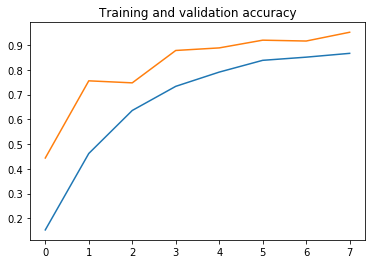

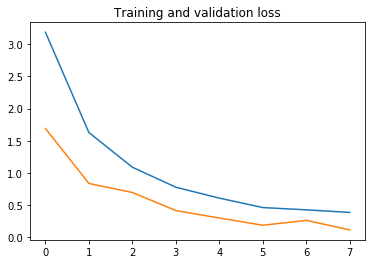

In [19]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [20]:
test_filenames = os.listdir("./input/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [21]:
test_df=test_df.drop(test_df.index[0])
test_df.shape

(100, 1)

In [23]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 100 validated image filenames.


In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [25]:
test_df['category'] = np.argmax(predict, axis=-1)

In [26]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

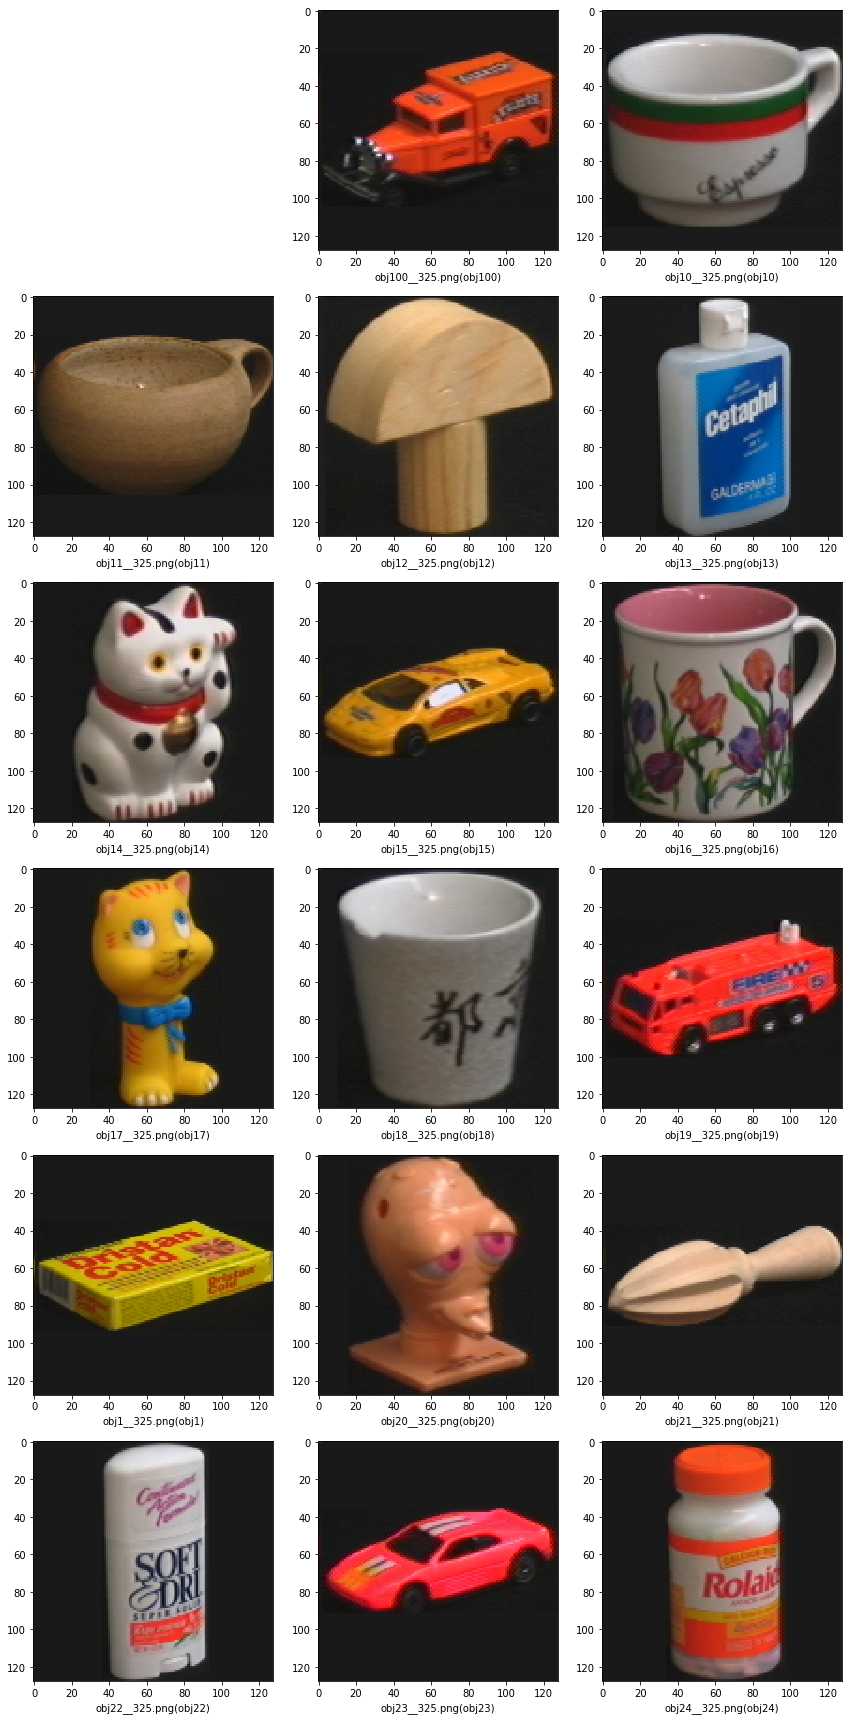

In [28]:
sample_test = test_df.head(17)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test/"+filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

